In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from geopandas import gpd
#from shapely import wkt
#from shapely.geometry import Point, LineString, shape, MultiPoint, box, Polygon, MultiLineString, mapping
#from shapely.ops import linemerge
import math
#import time
import timeit
    
%matplotlib inline

In [2]:
df = gpd.read_file("C:/Users/sarah/Downloads/Thesis_notebooks_and_data/Thesis_notebooks_and_data/Polygons_citycentre/Binnenstad_polygon.shp") 
df.crs = 28992  # this line
df = df.to_crs(epsg=28992)
polygon = df.geometry[0]
G = ox.graph_from_polygon(polygon, simplify=True, network_type='walk')
G = ox.projection.project_graph(G, to_crs=28992)

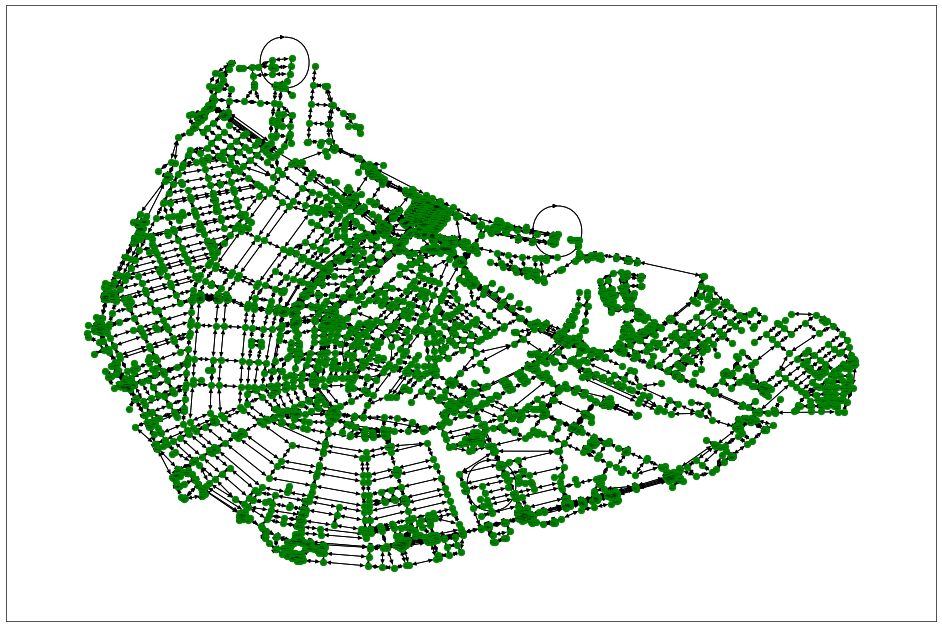

In [3]:
coo_list = []

for i in G.nodes:
    j = []
    j.append(G.nodes[i]['x'])
    j.append(G.nodes[i]['y'])
    coo_list.append(j)
    

count = 0
coo = {} #Empty dictionary to add values into

for i in coo_list:
    coo[list(G.nodes)[count]] = i
    count+=1

fig = plt.figure(1,figsize=(20,13.3333333333),dpi=60) 
ax = nx.draw_networkx(G, coo, node_color='green',node_size=60,font_size=1)

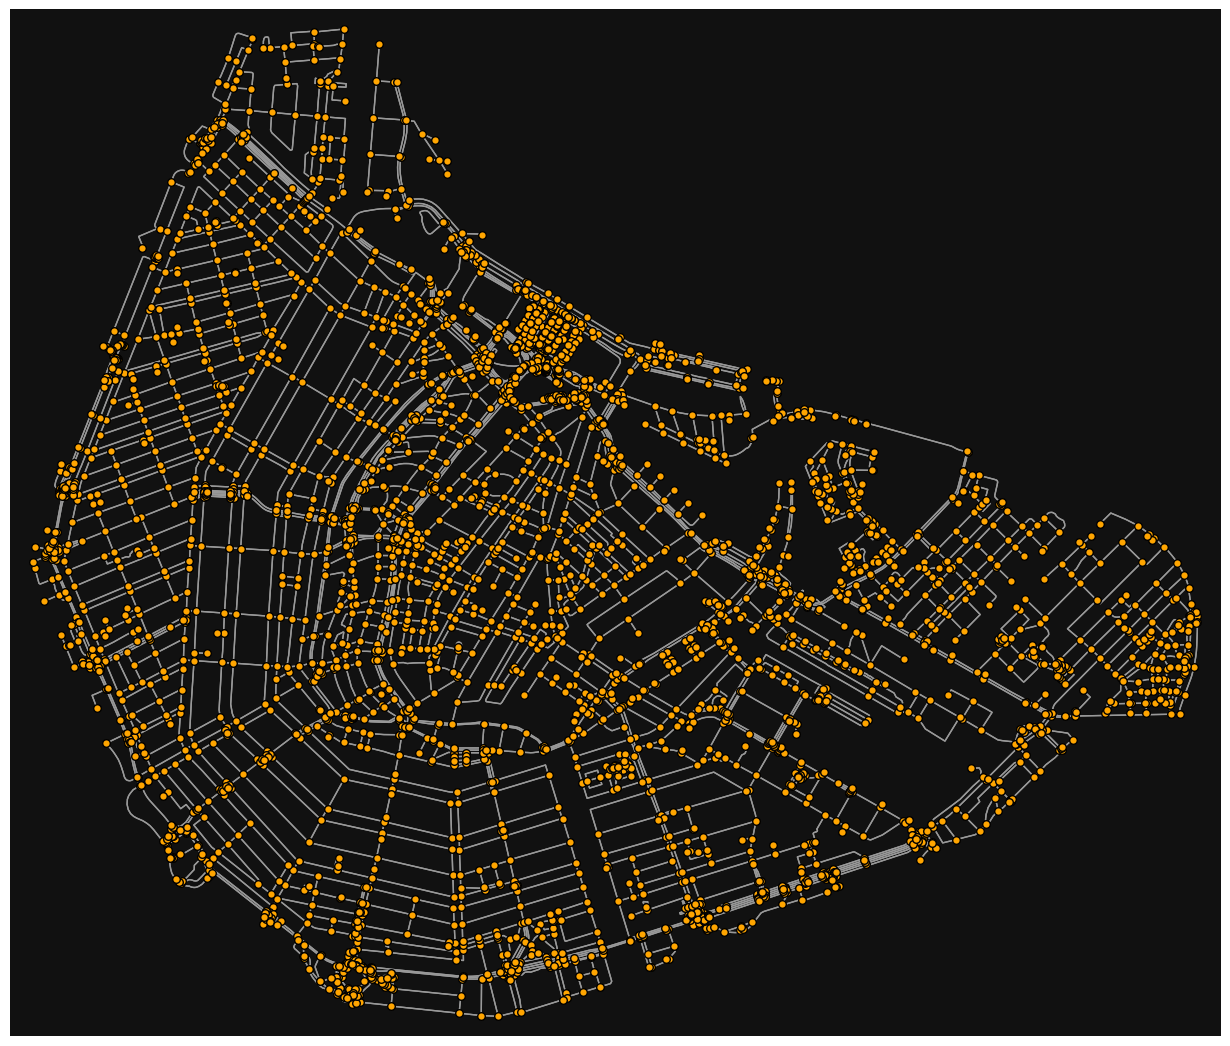

In [4]:
#plot the streets of grachtengordelzuid
fig, ax = ox.plot_graph(G, node_color='orange', node_size=30,
node_zorder=2, node_edgecolor='k', figsize=(20,13.3333333333),dpi=60)

In [5]:
G.size('length')

486929.0439999998

In [6]:
G1 = G.to_undirected()
nx.is_connected(G1)

True

In [7]:
df = pd.read_csv('results/outcome_wy_bc')

In [7]:
def sum_edges(graph):
    w_sum = 0
    l = len(graph.nodes)
    for i in range(l):
        for j in range(i,l):
            try:
                w_sum += graph[nn[i]][nn[j]][0]['length']
            except KeyError:
                pass

            
    return w_sum

In [8]:
def get_odd(graph):
    degrees = [0 for i in range(len(graph))]
    #nn = list(G.nodes)
    for i in range(len(nn)):
        degrees[i] = graph.in_degree(nn[i])
    
    degree1_n = [nn[i] for i in range(len(degrees)) if degrees[i]==1]
    degree1 = [i for i in range(len(degrees)) if degrees[i]==1]
    print('odds are:',degree1_n)
    return degree1_n

In [10]:
print(df.clusters.unique())
for i in df.clusters.unique():
    print(len(df.loc[df.clusters == i]))

[144. 135. 101. 140. 142. 139. 105.  78. 141. 134.  80. 147.  65.  60.
 145. 146.  53. 106. 117.  76.  35.  45.]
3724
2538
4412
5850
2105
2133
2189
2029
2456
3319
2949
2844
3025
1391
2259
1402
3514
1539
4206
1310
1066
1193


Warning: the following cell takes a long time to run (approximately 20 hours for the case of the inner city of Amsterdam)

In [11]:
start = timeit.default_timer()

all_edges = 0

# For each cluster
for i in df.clusters.unique():
    print('len cluster', i, 'is: ', len(df.loc[df.clusters == i]))
    data = df.loc[df.clusters == i]

    nn = []
    nearest_edges = []
    
    # Select the nearest street for each building
    for index, row in data.iterrows():
        edge = ox.distance.nearest_edges(G, row.x, row.y, return_dist=False)
        nearest_edges.append(edge)
        if edge[0] not in nn: 
            nn.append(edge[0])
        if edge[1] not in nn:
            nn.append(edge[1])

    # Create a graph containing all the street selected in the previous step
    H = G.subgraph(nn)
    print('stap 1: ', sum_edges(H))
    
    # Make this graph connected by identifying the shortest path between two selected subgraphs
    H = H.to_undirected()
    while nx.is_connected(H) is False:
        Z = H
        components = [Z.subgraph(c).copy() for c in nx.connected_components(Z)]
        subgraphA = []
        for idx,Z in enumerate(components,start=1):
            #print(f"Component {idx}: Nodes: {Z.nodes()} Edges: {Z.edges()}")
            subgraphA.append(Z.nodes)

        p = math.inf
        for i in subgraphA[0]:
            for j in subgraphA[1]:
                d = nx.shortest_path_length(G, i, j, weight='length')
                if d < p:
                    p = nx.shortest_path_length(G, i, j, weight='length')
                    x = i
                    y = j

        
        H.add_edge(x, y, length=p)
    print('stap 2: ', sum_edges(H))
    
    # Identify nodes with a degree = 1
    # these nodes will be connected to the nearest node with the shortest path, in order to create closed circuits
    H = H.to_directed()
    ys = []
    degree1_n = get_odd(H)
    for i in degree1_n:
        if i in ys:
            continue
        p = math.inf
        for j in H.nodes:
            if i == j:
                continue
            d = nx.shortest_path_length(G, i, j, weight='length')
            if d < p and H.has_edge(i, j) is False and H.has_edge(j, i) is False:
                p = nx.shortest_path_length(G, i, j, weight='length')
                x = i
                y = j
        ys.append(y)
        H.add_edge(x, y, length = p)
        
    print('stap 3: ', sum_edges(H))
    
    all_edges += sum_edges(H)
    print('Eind som: ', all_edges)
    
stop = timeit.default_timer()

print('Time: ', stop - start)

len cluster 117.0 is:  4743
stap 1:  10934.637999999995
stap 2:  11755.243999999995
odds are: [5832474320, 2102754848, 2324042739, 2324042730, 9315748305, 46460659, 10793733540, 8614352806, 2337046507, 1908220669, 5830936952, 46449725, 5830879763, 1799280606, 5713213414, 376530909, 2047996079, 5398669322]
stap 3:  12396.667999999996
Eind som:  12396.667999999996
len cluster 135.0 is:  3037
stap 1:  9695.313000000004
stap 2:  10521.598000000004
odds are: [2021881747, 7191491356, 4525422045, 5792760550, 3377191636, 3377142128, 1306733851, 3377136085, 3926140288, 10300767467]
stap 3:  10638.574000000004
Eind som:  23035.242
len cluster 101.0 is:  5285
stap 1:  18625.215999999993
stap 2:  19047.37899999999
odds are: [5794408307, 46419384, 1994069597, 539179315, 25752666, 3377085365, 46421801, 5761752107, 46361552, 3376816361, 10842922687]
stap 3:  19932.218999999994
Eind som:  42967.460999999996
len cluster 140.0 is:  5850
stap 1:  15096.706999999993
stap 2:  15305.399999999992
odds are: [

In [12]:
all_edges

173386.38